# PSO Projekt – Létesítmény-elhelyezés gráfon (sablon)

Cél: egy létesítmény optimális pozíciója 2D-ben, adott csúcspontok (városok)
és súlyok mellett, PSO használatával.

## 1. Városok / csúcsok definiálása

In [2]:
cities = [
    {"name": "A", "x": 0.0, "y": 0.0, "w": 4.0},
    {"name": "B", "x": 2.0, "y": 1.0, "w": 2.0},
    {"name": "C", "x": 4.0, "y": 0.5, "w": 1.0},
    {"name": "D", "x": 1.0, "y": 3.0, "w": 3.0},
    {"name": "E", "x": 3.0, "y": 3.5, "w": 1.0},
    {"name": "F", "x": 5.0, "y": 2.0, "w": 5.0}
]

len(cities)

6

## 2. Költségfüggvény – súlyozott távolságösszeg

In [4]:
import math

def facility_cost(position, cities):
    x, y = position
    total_cost = 0.0

    for city in cities:
        cx = city["x"]
        cy = city["y"]
        w  = city["w"]

        dist = math.sqrt((x - cx)**2 + (y - cy)**2)

        total_cost += w * dist

    return total_cost

# pos = [2.0, 2.0]
# print(facility_cost(pos, cities))

36.85912482383604


## 3. PSO építőelemek

In [5]:
import random

def random_vector(dim, lower, upper):
    """Dimenzió: dim, minden komponens ~ U(lower, upper)."""
    return [random.uniform(lower, upper) for _ in range(dim)]

def init_swarm(num_particles, dim, lower, upper, objective_fn):
    """
    Visszatérés:
      positions        – lista (num_particles darab dim-dimenziós pozíció)
      velocities       – lista (num_particles darab dim-dimenziós sebesség)
      pbest_positions  – kezdetben = positions
      pbest_values     – objective_fn(positions[i]) értékek
    """

    positions = []
    velocities = []
    pbest_positions = []
    pbest_values = []

    vel_lower = -(upper - lower)
    vel_upper = (upper - lower)

    for _ in range(num_particles):
        pos = random_vector(dim, lower, upper)
        positions.append(pos)

        vel = random_vector(dim, vel_lower, vel_upper)
        velocities.append(vel)

        pbest_positions.append(list(pos))
        pbest_values.append(objective_fn(pos))

    return positions, velocities, pbest_positions, pbest_values

## 4. PSO frissítés és kiértékelés

In [6]:
def update_velocities(positions, velocities, pbest_positions, gbest_position,
                      w=0.7, c1=1.5, c2=1.5, vmax=None):
    """Frissítsd az összes részecske sebességét a PSO-képlettel."""
    new_velocities = []
    for i in range(len(positions)):
        current_position = positions[i]
        current_velocity = velocities[i]
        pbest = pbest_positions[i]

        r1 = random.uniform(0, 1)
        r2 = random.uniform(0, 1)

        new_v = []
        for j in range(len(current_position)):
            cognitive_component = c1 * r1 * (pbest[j] - current_position[j])
            social_component = c2 * r2 * (gbest_position[j] - current_position[j])

            v_j = w * current_velocity[j] + cognitive_component + social_component

            if vmax is not None:
                v_j = max(-vmax, min(vmax, v_j))
            new_v.append(v_j)
        new_velocities.append(new_v)
    return new_velocities

def update_positions(positions, velocities, lower, upper):
    """Frissítsd a pozíciókat a sebességek alapján, és vágd vissza a tartományba."""
    new_positions = []
    for i in range(len(positions)):
        current_position = positions[i]
        current_velocity = velocities[i]

        new_x = []
        for j in range(len(current_position)):
            x_j = current_position[j] + current_velocity[j]

            x_j = max(lower, min(upper, x_j))
            new_x.append(x_j)
        new_positions.append(new_x)
    return new_positions

def evaluate_swarm(positions, pbest_positions, pbest_values, objective_fn):
    """
    positions: aktuális pozíciók
    pbest_positions, pbest_values: eddigi legjobb értékek és pozíciók
    objective_fn: minimalizálandó függvény

    Visszatérés:
      pbest_positions, pbest_values, gbest_position, gbest_value
    """
    gbest_value = float('inf')
    gbest_position = None

    for i in range(len(positions)):
        current_position = positions[i]
        current_value = objective_fn(current_position)

        if current_value < pbest_values[i]:
            pbest_values[i] = current_value
            pbest_positions[i] = list(current_position)

        if pbest_values[i] < gbest_value:
            gbest_value = pbest_values[i]
            gbest_position = list(pbest_positions[i])

    return pbest_positions, pbest_values, gbest_position, gbest_value

## 5. Fő PSO-ciklus létesítmény-elhelyezésre

In [19]:
def run_pso_facility(
    cities,
    num_particles=30,
    dim=2,
    lower=-10,
    upper=10,
    w=0.7,
    c1=1.5,
    c2=1.5,
    vmax=None,
    n_iters=100
):
    objective_fn = lambda pos: facility_cost(pos, cities)

    positions, velocities, pbest_positions, pbest_values = init_swarm(
        num_particles, dim, lower, upper, objective_fn
    )

    history = []
    swarm_history = []

    for it in range(n_iters):
        pbest_positions, pbest_values, gbest_position, gbest_value = evaluate_swarm(
            positions, pbest_positions, pbest_values, objective_fn
        )

        history.append(gbest_value)

        velocities = update_velocities(
            positions, velocities, pbest_positions, gbest_position,
            w=w, c1=c1, c2=c2, vmax=vmax
        )

        positions = update_positions(positions, velocities, lower, upper)

        if it % 20 == 0 or it == n_iters-1:# Csak minden 20-dikat írtam ki, mert különben túl sok lenne
            print(f"Iteráció {it:3d} | gbest = {gbest_value:.4f} - {gbest_position} pozicióban")

        swarm_history.append([pos[:] for pos in positions])

    return gbest_position, gbest_value, history, swarm_history

In [21]:
best_pos, best_val, history, swarm_history = run_pso_facility(
    cities,
    num_particles=50,
    dim=2,
    lower=-1,
    upper=6,
    n_iters=200
)

print("\nLegjobb facility hely:", best_pos)
print("Költsége:", best_val)

Iteráció   0 | gbest = 36.0260 - [2.2182696517014806, 1.6437867187038107] pozicióban
Iteráció  20 | gbest = 35.9021 - [2.2142273098334595, 1.4078060484396941] pozicióban
Iteráció  40 | gbest = 35.9021 - [2.215302576686101, 1.4057456068709406] pozicióban
Iteráció  60 | gbest = 35.9021 - [2.215316413767057, 1.4064978896027356] pozicióban
Iteráció  80 | gbest = 35.9021 - [2.2153898711781697, 1.4064951244253876] pozicióban
Iteráció 100 | gbest = 35.9021 - [2.215388832883188, 1.4064940332016838] pozicióban
Iteráció 120 | gbest = 35.9021 - [2.215388744715999, 1.4064940523101486] pozicióban
Iteráció 140 | gbest = 35.9021 - [2.215388706636989, 1.40649404493311] pozicióban
Iteráció 160 | gbest = 35.9021 - [2.215388689584379, 1.4064940131420887] pozicióban
Iteráció 180 | gbest = 35.9021 - [2.215388689584379, 1.4064940131420887] pozicióban
Iteráció 199 | gbest = 35.9021 - [2.215388689584379, 1.4064940131420887] pozicióban

Legjobb facility hely: [2.215388689584379, 1.4064940131420887]
Költsége: 3

## 6. Vizualizáció és kísérletek

In [23]:
import matplotlib.pyplot as plt

def plot_solution(cities, best_position):
    """
    Városok + legjobb facility pozíció kirajzolása.
    """

    xs = [c["x"] for c in cities]
    ys = [c["y"] for c in cities]
    ws = [c["w"]*80 for c in cities]  # nagyobbak legyenek a körök

    plt.figure(figsize=(7,7))

    plt.scatter(xs, ys, s=ws, c="blue", alpha=0.6, label="Városok")

    for c in cities:
        plt.text(c["x"] + 0.05, c["y"] + 0.05, c["name"])

    bx, by = best_position
    plt.scatter([bx], [by], c="red", marker="X", s=200, label="Optimális hely")

    for c in cities:
        plt.plot([bx, c["x"]], [by, c["y"]], "gray", alpha=0.3)

    plt.title("Városok és optimális facility helye (PSO eredmény)")
    plt.xlabel("X koordináta")
    plt.ylabel("Y koordináta")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_convergence(history, title="PSO – facility placement"):
    plt.figure(figsize=(7,4))
    plt.plot(history, linewidth=2)
    plt.title(title)
    plt.xlabel("Iteráció")
    plt.ylabel("Legjobb költség")
    plt.grid(True)
    plt.show()

In [28]:
from matplotlib.animation import FuncAnimation
import numpy as np

#Egy kis érdekesség amit talatam és összeraktam a keresgélésem során
def animate_particles(cities, swarm_history, interval=150):
    fig, ax = plt.subplots(figsize=(7,7))

    xs = [c["x"] for c in cities]
    ys = [c["y"] for c in cities]
    ws = [c["w"]*80 for c in cities]

    ax.scatter(xs, ys, s=ws, c="blue", alpha=0.6)

    scat = ax.scatter([], [], c="red", s=40)

    ax.set_title("PSO részecskék mozgása")
    ax.set_xlim(min(xs)-1, max(xs)+1)
    ax.set_ylim(min(ys)-1, max(ys)+1)
    ax.grid(True)

    def update(frame):
        swarm = swarm_history[frame]
        P = np.array(swarm)
        scat.set_offsets(P)
        ax.set_title(f"Iteráció: {frame}")
        return scat,

    anim = FuncAnimation(fig, update, frames=len(swarm_history),
                         interval=interval, blit=True)

    return anim

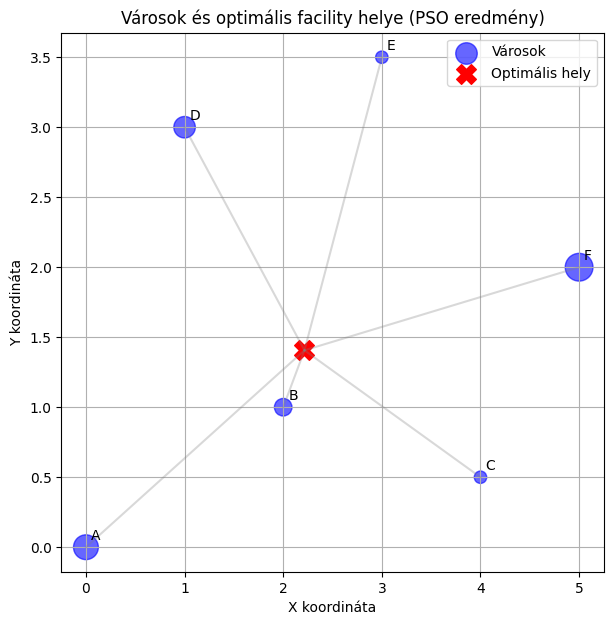

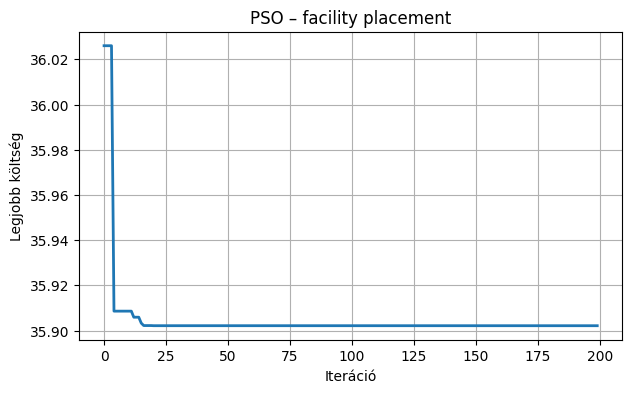

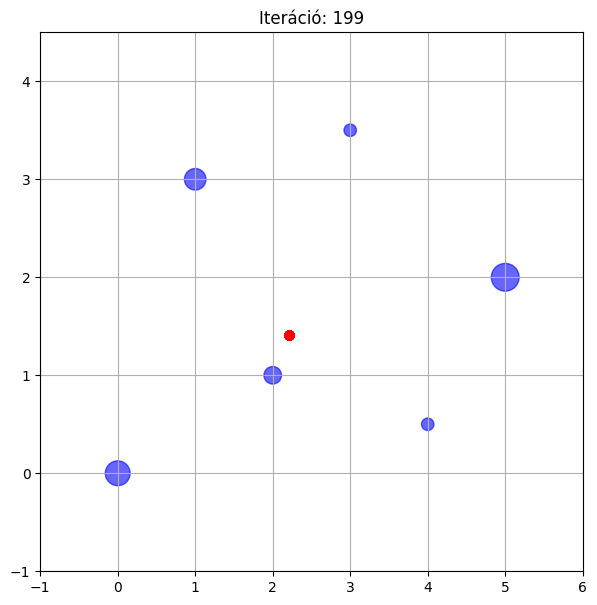

In [30]:
from IPython.display import HTML

plot_solution(cities, best_pos)
plot_convergence(history)
anim = animate_particles(cities, swarm_history)
HTML(anim.to_jshtml())

## 7. Szöveges összefoglaló

###Paraméterek:
Városok: Hat város lett definiálva (cities lista), mindegyikhez tartozott egy név, x és y koordináta, valamint egy súly (w). Ez a súly reprezentálhatja például a népességet vagy a keresletet. (Pl.: A: (0,0), w=4; F: (5,2), w=5).

Költségfüggvény: A súlyozott távolságösszeg, ahol a létesítmény és az egyes városok közötti euklideszi távolságot megszorozzuk az adott város súlyával, majd ezeket összegezzük. Cél a költség minimalizálása.

**PSO Beállítások:**
* num_particles (részecskék száma): 50
* dim (dimenzió): 2 (x és y koordináták)
* lower (alsó határ): -1
* upper (felső határ): 6
* n_iters (iterációk száma): 200
* w (inerszións faktor): 0.7 (alapértelmezett)
* c1 (kognitív súly): 1.5 (alapértelmezett)
* c2 (szociális súly): 1.5 (alapértelmezett)
###Eredmények:
Optimális létesítmény helye (best_pos): [2.215388689584379, 1.4064940131420887]
Minimális költség (best_val): 35.90212064223556
###PSO viselkedéséről szóló megfigyelések:
Gyors konvergencia: Az algoritmus már viszonylag kevés iteráció után elkezdett konvergálni. A kimenet alapján az első 20-40 iterációban már jelentősen csökkent a gbest érték, majd utána csak finomhangolódott.

Stabilitás: Az iterációk előrehaladtával (körülbelül a 40. iterációtól) a gbest érték már nagyon stabil maradt, ami arra utal, hogy az algoritmus megtalált egy lokális (és valószínűleg globális) optimumot a megadott keresési tartományban.

Részecskék mozgása (az animáció alapján): Az animáció vizuálisan is jól mutatja a PSO működését. A kezdetben véletlenszerűen szétszórt részecskék fokozatosan gyűlnek össze a talált optimális pont körül, demonstrálva a kognitív és szociális komponensek hatását, ahogy a részecskék tanulnak saját legjobb tapasztalataikból és a raj legjobb tapasztalataiból.

Súlyozott eltolódás: Az optimális pont nem egyszerűen a városok geometriai középpontja, hanem a nagyobb súlyú városok (pl. 'A' és 'F') felé tolódik, ami összhangban van a súlyozott távolságösszeg minimalizálásának céljával.